# Significant words

https://moodle2.uni-leipzig.de/pluginfile.php/2889299/mod_resource/content/0/distant_readingII.pdf

In [1]:
import pandas as pd

exact_matches = pd.read_parquet("../results/artists_exact_match_large.parquet", engine='pyarrow')
assert "artists" in exact_matches.columns, f'artists is not in {exact_matches.columns}'
assert "num_artists" in exact_matches.columns, f'num_artists is not in {exact_matches.columns}'

print(f'exact match shapes {exact_matches.shape}')

import my_utils


artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')

exact match shapes (1819808, 5)


In [2]:
import wordcloud
from collections import defaultdict
import re

def read_stopwords():
    # from https://gist.github.com/sebleier/554280
    return my_utils.read_lines_as_list("stopwords.txt")

def compute_corpus(df, col):
    # print(sw)
    corpus = []
    for i, row in df.iterrows():
        string = row[col]
        words = []
        for s in re.split("[, \-!?:\.]+", string):
            s=s.strip().lower()
            if len(s)>0:
                words.append(s)
        corpus.append(" ".join(words))
    return corpus
    

In [3]:
print(f'exact matches columns {exact_matches.columns}')
corpus = exact_matches.prompt.to_list()
print(len(corpus))
print(corpus[0])
corpus_greg = my_utils.exact_match_dataframe(exact_matches, "greg rutkowski").prompt.to_list()
print(len(corpus_greg))
print(corpus_greg[0])

exact matches columns Index(['prompt', 'image_name', 'user_name', 'artists', 'num_artists'], dtype='object')
1819808
beautiful porcelain ivory fair face woman biomechanical cyborg, close - up, sharp focus, studio light, iris van herpen haute couture headdress made of rhizomorphs, daisies, brackets, colorful corals, fractal mushrooms, puffballs, octane render, ultra sharp, 8 k 
180080
rimworld concept art isometric perspective, epic, by victo ngai, kilian eng vibrant colours, dynamic lighting, digital art, winning award masterpiece, fantastically beautiful, illustration, inspired by beksinski and dan mumford, trending on artstation, by greg rutkowski, 8 k 


In [4]:
stopwords = read_stopwords()
stopwords.append("greg")
stopwords.append("rutkowski")

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
print(f'{X.shape[0]} documents')
print(f'{X.shape[1]} words')
print(feature_names)

1819808 documents
171526 words
['00' '000' '0000' ... '𝙁𝙧𝙞𝙚𝙙𝙧𝙞𝙘𝙝' '𝟖𝖐' '𝟭𝟴𝟬𝟬']


In [9]:
import pandas as pd

word_weight_indices = X.nonzero()[1]
word_occurences = defaultdict(lambda: 0)
for w in word_weight_indices:
    word_occurences[w]=word_occurences[w]+1

mean_tf_idfs = X.mean(axis=0)
print(mean_tf_idfs.shape)
mapping={}
print(mean_tf_idfs[0,0])
for index, fn in enumerate(feature_names):
    mapping[fn]=[mean_tf_idfs[0,index], word_occurences[index]]

df = pd.DataFrame.from_dict(mapping, orient="index", columns = ["tf_idf", "query_mentions"])

df.sort_values("tf_idf", axis=0, ascending=False, inplace=True)
print(df.head(20))

(1, 171526)
1.2021336090849347e-05
                tf_idf  query_mentions
art           0.030218          475447
detailed      0.025573          517319
painting      0.020543          338546
artstation    0.020055          385409
portrait      0.018501          320059
highly        0.015804          264516
digital       0.015709          246244
lighting      0.014851          246205
beautiful     0.014053          214221
trending      0.013705          215987
concept       0.013324          206185
style         0.013126          180015
intricate     0.012837          213336
realistic     0.012733          176837
illustration  0.012186          177965
cinematic     0.011968          182323
render        0.011903          169551
sharp         0.011878          189600
focus         0.011560          174561
high          0.011499          153974


## Tf Idf Rankings computed of the corpus only containing the greg rutkowski prompts

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer_greg = TfidfVectorizer(stop_words=stopwords)
X_greg = vectorizer_greg.fit_transform(corpus_greg)
feature_names_greg = vectorizer_greg.get_feature_names_out()
print(f'{X_greg.shape[0]} documents')
print(f'{X_greg.shape[1]} words')
print(feature_names_greg)

import pandas as pd

from collections import defaultdict

word_weight_indices_greg = X_greg.nonzero()[1]
word_occurences_greg = defaultdict(lambda: 0)
for w in word_weight_indices_greg:
    word_occurences_greg[w]=word_occurences_greg[w]+1

mean_tf_idfs_greg = X_greg.mean(axis=0)
print(mean_tf_idfs_greg.shape)
mapping_greg={}
print(mean_tf_idfs_greg[0,0])
for index, fn in enumerate(feature_names_greg):
    mapping_greg[fn]=[mean_tf_idfs_greg[0,index], word_occurences_greg[index]]

df_greg = pd.DataFrame.from_dict(mapping_greg, orient="index", columns = ["tf_idf", "query_mentions"])

df_greg.sort_values("tf_idf", axis=0, ascending=False, inplace=True)
print(f'total number of words {len(corpus_greg)}')
print(df_greg.head(20))

180080 documents
41006 words
['00' '000' '000000' ... '薯子' '薯子imoko' '香川悠作']
(1, 41006)
1.7522102420448725e-05
total number of words 180080
                tf_idf  query_mentions
art           0.060725          108263
detailed      0.040576          103229
artstation    0.037570           95503
painting      0.036490           80979
digital       0.033992           72623
highly        0.033163           72394
concept       0.031882           67277
focus         0.031796           59835
artgerm       0.031199           66388
sharp         0.030984           65132
illustration  0.030967           58076
portrait      0.030363           65358
intricate     0.029254           60660
mucha         0.028124           54367
alphonse      0.027742           52495
fantasy       0.025377           41814
trending      0.024032           43613
smooth        0.021364           34830
lighting      0.021268           37852
elegant       0.021204           34036


(171526, 6)
   word_plain  tf_idf_plain  query_mentions word_artist  tf_idf_artist  \
0         art      0.030218          475447         art       0.060725   
1    detailed      0.025573          517319    detailed       0.040576   
2    painting      0.020543          338546  artstation       0.037570   
3  artstation      0.020055          385409    painting       0.036490   
4    portrait      0.018501          320059     digital       0.033992   

   query_mentions  
0        108263.0  
1        103229.0  
2         95503.0  
3         80979.0  
4         72623.0  
tail
       word_plain  tf_idf_plain  query_mentions word_artist  tf_idf_artist  \
171521     dawnin  3.039500e-08               1         NaN            NaN   
171522    lantana  2.899673e-08               1         NaN            NaN   
171523   portmans  2.899673e-08               1         NaN            NaN   
171524     finded  2.486355e-08               1         NaN            NaN   
171525  731006521  1.232770e

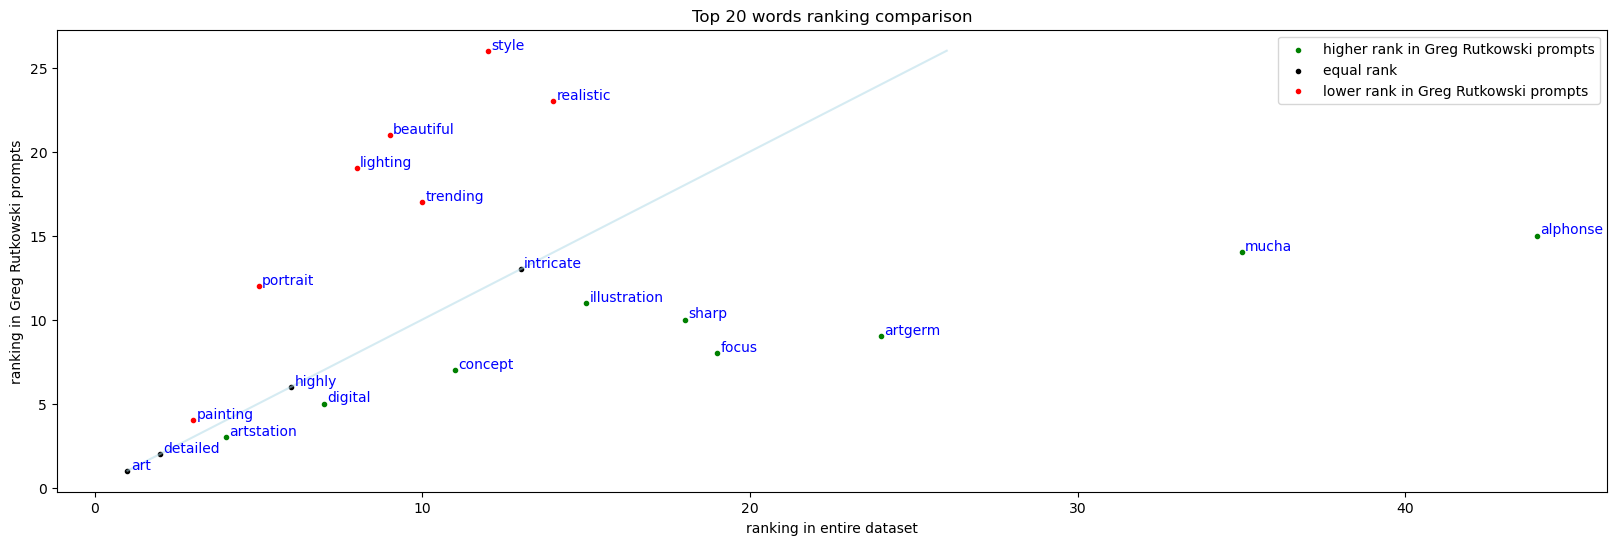

In [11]:
import visualize_rankings as vr
    
ranking_amount=20    
vr.visualize_tf_idf_rankings(mapping, mapping_greg, "Greg Rutkowski", ranking_amount)

# the average tf*idf is not computed over the non_zero values

When computing only over non_zero weights, we get total garbage (low frequency words).

In [12]:
# mean of non-zero
import numpy as np

sums = np.sum(X, axis=0)

nonzero_mean = sums

from collections import defaultdict

word_weight_indices = X.nonzero()[1]
word_occurences = defaultdict(lambda: 0)
for w in word_weight_indices:
    word_occurences[w]=word_occurences[w]+1

for index in range (nonzero_mean.shape[1]): #iterate over the elements
    amount_nonzero = word_occurences[index]
    if index==0:
        print(f'should be 62: {amount_nonzero}')
        assert amount_nonzero == 62
    tf_idf_sum = sums[0, index]
    nonzero_mean[0, index] = tf_idf_sum / amount_nonzero


mean_tf_idfs = nonzero_mean
print(mean_tf_idfs.shape)
mapping={}
print(mean_tf_idfs[0,0])
for index, fn in enumerate(feature_names):
    mapping[fn]=[mean_tf_idfs[0,index], word_occurences[index]]

df = pd.DataFrame.from_dict(mapping, orient="index", columns = ["tf_idf", "query_mentions"])

df.sort_values("tf_idf", axis=0, ascending=False, inplace=True)
print(df.head())
print(df[df["query_mentions"]>100].head())

should be 62: 62
(1, 171526)
0.35284715465832867
                                      tf_idf  query_mentions
msi                                      1.0               1
piratesofthecarribeandavyjoneslocker     1.0               1
strawbasil                               1.0               1
foobar                                   1.0               1
jewelpet                                 1.0               1
            tf_idf  query_mentions
plumbus   0.642911             147
bundt     0.599701             148
funniest  0.590097             136
neymar    0.585640             118
img       0.581835             109


In [ ]:
from collections import defaultdict
print(X.nonzero())
print(X.nonzero()[0].shape)
print(X.nonzero()[1].shape)
word_weight_indices = X.nonzero()[1]
word_occurences = defaultdict(lambda: 0)
for w in word_weight_indices:
    word_occurences[w]=word_occurences[w]+1
print('finished')
    
    
col0=X.getcol(0)
nz = col0.nonzero()
print(nz)
print(nz[0].shape)
print(nz[1].shape)
print(col0.shape)
print(col0)



inverse = vectorizer.inverse_transform(X)
print(inverse)
print(inverse.shape)

(array([      0,       0,       0, ..., 1819807, 1819807, 1819807],
      dtype=int32), array([156179, 125508, 108201, ..., 111590,  61803, 144630], dtype=int32))
(30385455,)
(30385455,)
finished
(array([ 375467,  400323,  400324,  599848,  621304,  666468,  667988,
        669696,  679267,  706823,  903454,  903455,  903456, 1045087,
       1181732, 1212395, 1212396, 1212397, 1247311, 1247312, 1282279,
       1282830, 1290757, 1316384, 1394953, 1397215, 1397216, 1399255,
       1434904, 1436079, 1474652, 1512482, 1513107, 1513108, 1594213,
       1594734, 1595675, 1595676, 1595677, 1595678, 1596355, 1597346,
       1597347, 1597348, 1597349, 1597350, 1674239, 1674240, 1674241,
       1674796, 1798147, 1798148, 1798697, 1798698, 1804526, 1804572,
       1804642, 1804643, 1804962, 1804963, 1804964, 1804965], dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0,

# Check if results are really different from frequency ranking

Yes they are different but not by much.

In [ ]:
from collections import defaultdict
import re

def read_stopwords():
    # from https://gist.github.com/sebleier/554280
    return my_utils.read_lines_as_list("stopwords.txt")

def compute_freq(df, col):
    sw = read_stopwords()
    # print(sw)
    freq = defaultdict(lambda: 0)
    for i, row in df.iterrows():
        string = row[col]
        for s in re.split("[, \-!?:]+", string):
            s=s.strip().lower()
            if s not in sw:
                if len(s)>0:
                    freq[s]=freq[s]+1
    return freq
    
def remove(freqs, words):
    
    result = defaultdict(lambda: 0)
    for key, value in freqs.items():
        #print(f'key {key}, value {value}')
        if key not in words:
            result[key]=value
    return result

freqs = compute_freq(exact_matches, "prompt")
freqs = remove(freqs, ["greg", "rutkowski"])
print(f'finished')

freqs_df = pd.DataFrame.from_dict(freqs, orient="index", columns = ["counts_plain"])
freqs_df.index.name = 'word_plain'

freqs_df.sort_values("counts_plain", axis=0, ascending=False, inplace=True)
#freqs_df['length']=freqs_df.word_plain.apply(lambda x: len(x))
freqs_df.reset_index(inplace=True)
freqs_sum = freqs_df.counts_plain.sum()
freqs_df['frequency_plain']=freqs_df.counts_plain.apply(lambda x: x / freqs_sum)

print(freqs_df.head(20))